In [1]:
import pandas_profiling
import datetime
from datetime import timedelta
import time
import pandas as pd
import matplotlib as plt
import seaborn as sns
import json
import numpy as np


In [2]:
## Import files:

earthquake_df = pd.read_csv('usgs_mag5_1990_2019.csv')
aqs_df = pd.read_csv('final_aq.csv')

In [3]:
#We have a large enoug N to drop the NA measurements 
aqs_df.dropna()

,Unnamed: 0,q_ueid,Parameter,P_id,Station,Date,County,Measurement,Unit
0,0,ci10180015,Carbon monoxide,42101,2,1999-10-09,Los Angeles,0.9,Parts per million
1,1,ci10180015,Carbon monoxide,42101,2,1999-10-09,Los Angeles,0.7,Parts per million
2,2,ci10180015,Carbon monoxide,42101,2,1999-10-09,Los Angeles,0.7,Parts per million
3,3,ci10180015,Carbon monoxide,42101,2,1999-10-09,Los Angeles,0.7,Parts per million
5,5,ci10180015,Carbon monoxide,42101,2,1999-10-09,Los Angeles,0.9,Parts per million
...,...,...,...,...,...,...,...,...,...
1478835,1478835,uw10530748,Sulfur dioxide,42401,80,2001-03-07,King,19.0,Parts per billion
1478836,1478836,uw10530748,Sulfur dioxide,42401,80,2001-03-07,King,23.0,Parts per billion
1478837,1478837,uw10530748,Sulfur dioxide,42401,80,2001-03-07,King,15.0,Parts per billion
1478838,1478838,uw10530748,Sulfur dioxide,42401,80,2001-03-07,King,6.0,Parts per billion


C:\tools\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\tools\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\tools\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\tools\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


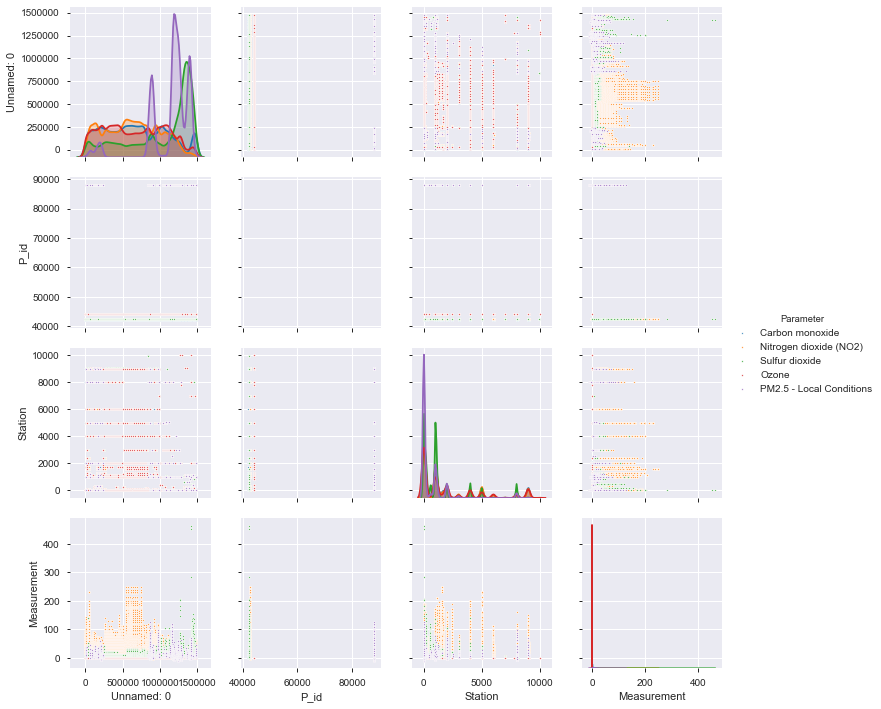

In [9]:
sns.pairplot(data=aqs_df, hue = 'Parameter', plot_kws={'s':3})

In [ ]:
# I need to figure out a way to calculate the day distance to the even from each measurement:
# event_date - measurement date = time_delta could be a time delta or an integer but just day. 15 bins [-7,-6,...,-1,0,1,...6,7]
#earthquake_df = earthquake_df.drop(index='Unnamed: 0')
aqs_df.keys()

In [58]:
event_date = earthquake_df[['Identifier', 'Date']]
aqs_df = aqs_df.rename(columns={'q_ueid':'Identifier'})
master_record = aqs_df.merge(earthquake_df, on='Identifier', suffixes=('_measure', '_event'))

# raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f
master_record['Date_measure'] = pd.to_datetime(master_record['Date_measure'])
master_record['Date_event'] = pd.to_datetime(master_record['Date_event'], format='%Y%m%d')
master_record['time_bins'] =(master_record['Date_measure']-master_record['Date_event']).dt.days
clean_record = master_record[['Parameter','Measurement', 'Unit', 'County', 'Location', 'GCS', 'Depth', 'Magnitude', 'Date_measure', 'Date_event', 'time_bins']]
pollutant_list = clean_record['Parameter'].unique().tolist()
pollutant_list

['Carbon monoxide',
 'Nitrogen dioxide (NO2)',
 'Sulfur dioxide',
 'Ozone',
 'PM2.5 - Local Conditions']

In [ ]:
clean_record.to_csv('final_epa_usgs_df.csv')

[(0, 300)]

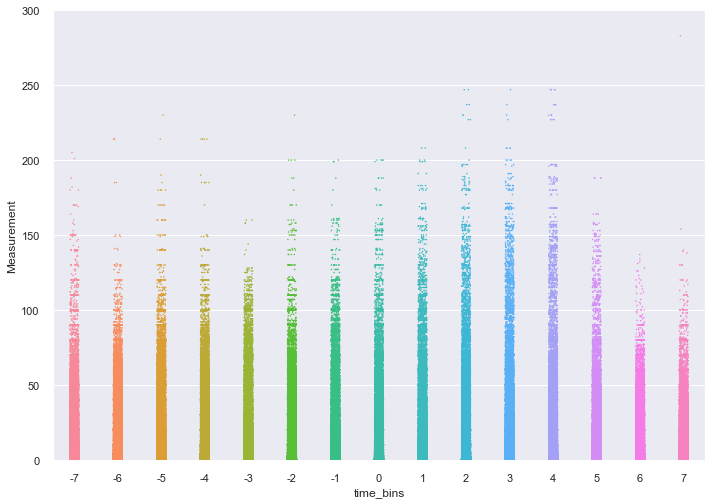

In [80]:
#Iterate over this to make graphs for each pollutant:
ax = sns.stripplot(x=clean_record['time_bins'], y = clean_record['Measurement'], data = clean_record[clean_record['Parameter'] == 'Sulfur dioxide'], marker='.', s=3)
ax.set(ylim=(0, 300))


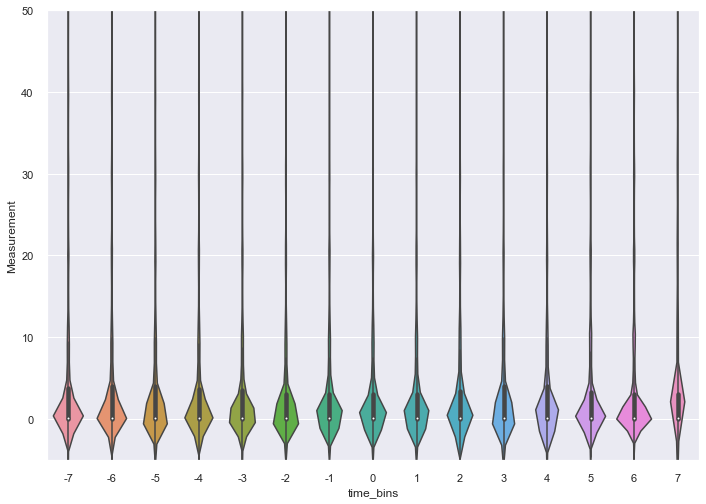

In [86]:
#g = sns.FacetGrid(clean_record, col='Parameter', hue='Unit', col_wrap=5)
sns.set(rc={'figure.figsize':(11.7,8.27)})
#Iterate over this to make graphs for each pollutant:
ax = sns.violinplot(x=clean_record['time_bins'], y = clean_record['Measurement'], data = clean_record[clean_record['Parameter'] == 'Sulfur dioxide'], marker='.', s=3)
ax.set(ylim=(-5, 50))
ax

In [24]:
clean_record.to_csv('final_epa_usgs_df.csv')

In [82]:
clean_record[clean_record['Parameter']=='Sulfur dioxide']['Measurement'].describe()

count    267662.000000
mean          1.470103
std           4.102984
min          -1.700000
25%           0.000000
50%           0.000000
75%           1.600000
max         464.000000
Name: Measurement, dtype: float64

In [25]:
clean_record['time_bins']

0         -7
1         -7
2         -7
3         -7
4         -7
          ..
1478835    7
1478836    7
1478837    7
1478838    7
1478839    7
Name: time_bins, Length: 1478840, dtype: int64